In [51]:
import nibabel as nib
import numpy as np
import os

def normalise_nii(patient_folder_path, output_folder, modality='t2'):
    """
    Load a specific modality NIfTI file from a patient folder, perform intensity normalization, 
    and save to a new NIfTI file in the output folder.
    Normalization is done per channel, only on non-zero voxels (brain tissue).
    
    Args:
        patient_folder_path: Path to the patient folder (e.g., BraTS20_Training_001)
        output_folder: Path where normalised file will be saved
        modality: Modality to process ('flair', 't1', 't1ce', 't2'). Default is 't2'.
    """
    try:
        # Get patient ID from folder name
        patient_id = os.path.basename(patient_folder_path)
        
        # Construct the modality file path
        input_nii_path = os.path.join(patient_folder_path, f"{patient_id}_{modality}.nii")
        input_seg_path = os.path.join(patient_folder_path, f"{patient_id}_seg.nii")
        
        # Load the NIfTI file
        nii_img = nib.load(input_nii_path)
        image = nii_img.get_fdata()
        
        # Normalise the image data
        if image.ndim == 4:  # Multi-channel (W, H, D, C) or similar 4D structure
            normalised_image = np.zeros_like(image, dtype=np.float32)
            for channel in range(image.shape[-1]):  # Assuming channels are last dimension
                channel_data = image[..., channel]
                mask_brain = channel_data > 0
                if mask_brain.any():
                    mean = channel_data[mask_brain].mean()
                    std = channel_data[mask_brain].std()
                    normalised_image[..., channel] = (channel_data - mean) / (std + 1e-8)
        else:  # Single channel 3D volume (W, H, D)
            mask_brain = image > 0
            if mask_brain.any():
                mean = image[mask_brain].mean()
                std = image[mask_brain].std()
                normalised_image = (image - mean) / (std + 1e-8)
            else:
                normalised_image = image.copy()
        
        # Create new NIfTI image with same header/affine as original
        normalised_nii = nib.Nifti1Image(normalised_image.astype(np.float32), 
                                        nii_img.affine, 
                                        nii_img.header)
        
        output_sub_folder = os.path.join(output_folder, patient_id)
        os.makedirs(output_sub_folder, exist_ok=True)
        output_nii_path = os.path.join(output_sub_folder, f"{patient_id}_{modality}.nii")
        output_seg_path = os.path.join(output_sub_folder, f"{patient_id}_seg.nii")
        
        # Save the normalised NIfTI file
        nib.save(normalised_nii, output_nii_path)
        # Copy the segmentation file to the output folder without changes
        nib.save(nib.load(input_seg_path), output_seg_path)

        return True
    
    except Exception as e:
        print(f"Failed to normalise: {patient_folder_path}. Got error: {e}")
        return False


# Example usage:
# normalise_nii('/path/to/BraTS20_Training_001', '/path/to/output_folder')

In [66]:
import nibabel as nib
import matplotlib.pyplot as plt
import os

def display_middle_slice_nii(patient_path, modality='t2'):
    """
    Opens NIfTI files and displays the middle slice of the scan and the mask.
    
    Args:
        patient_path: Path to the patient folder containing NIfTI files
        modality: Which modality to display ('flair', 't1', 't1ce', 't2'). Default is 't2'.
    """
    patient_id = os.path.basename(patient_path)
    
    # Load the specific modality
    modality_file = os.path.join(patient_path, f"{patient_id}_{modality}.nii")
    img = nib.load(modality_file).get_fdata()
    
    # Load the segmentation mask
    seg_file = os.path.join(patient_path, f"{patient_id}_seg.nii")
    mask = nib.load(seg_file).get_fdata()
    
    # Determine the middle slice index along the depth axis
    # BraTS is typically 155 slices deep (axis 2)
    mid_idx = img.shape[2] // 2
    
    # Extract the middle slice
    slice_img = img[:, :, mid_idx]
    slice_mask = mask[:, :, mid_idx]
    
    # Plotting
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.title(f"Middle Slice ({mid_idx}) - {modality.upper()}")
    im = plt.imshow(slice_img.T, cmap='gray', origin='lower')
    plt.colorbar(im, label='Magnitudes')
    plt.axis('on')

    plt.subplot(1, 2, 2)
    plt.title(f"Middle Slice ({mid_idx}) - Mask")
    plt.imshow(slice_mask.T, cmap='jet', origin='lower')  # 'jet' helps the tumor labels pop
    plt.axis('on')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Displayed middle slice {mid_idx} from {patient_id} - {modality.upper()}")

# Example usage:
# display_middle_slice_nii('/path/to/BraTS20_Training_001', modality='flair')
# display_middle_slice_nii('/path/to/BraTS20_Training_001', modality='t1ce')

In [58]:
import glob
import os
from pathlib import Path

cwd = Path.cwd()
print("Current working directory:", cwd) # /rds/general/user/km1422/home
root_path = cwd.parent/"projects"/"brainwearcwa"/"live"/"BrainWear_Kareem"

# Set paths
brats_root = root_path/"BraTS2020_TrainingData"/"MICCAI_BraTS2020_TrainingData"
search_pattern = str(brats_root/"BraTS20_Training_*")

patient_folders = glob.glob(search_pattern)

# Check all patient folders are present
assert len(patient_folders) == 369, f"Expected 369 patient folders in the BraTS20_TrainingData directory, found {len(patient_folders)}."
print(f"Found {len(patient_folders)} patient folders. All present")

# Check patient folder contains expected files
expected_files = ['flair', 't1', 't1ce', 't2', 'seg']
sample_patient = brats_root/"BraTS20_Training_001" #patient_folders[0]  # Just check any
print(f"Sample patient: {sample_patient}")
for mod in expected_files:
    file_path = os.path.join(sample_patient, f"{os.path.basename(sample_patient)}_{mod}.nii")
    assert os.path.exists(file_path), f"Expected file {file_path} not found in {sample_patient}."
print(f"Sample patient folder {os.path.basename(sample_patient)} contains all expected files.")

# Check output path exists
output_path = root_path/'Processed_BraTS2020_TrainingData'
os.makedirs(output_path, exist_ok=True)
assert os.path.exists(output_path), f"Output path {output_path} does not exist. Please create it before running the conversion."
print(f"Output path {output_path} is valid.")

Current working directory: /rds/general/user/km1422/home
Found 369 patient folders. All present
Sample patient: /rds/general/user/km1422/projects/brainwearcwa/live/BrainWear_Kareem/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001
Sample patient folder BraTS20_Training_001 contains all expected files.
Output path /rds/general/user/km1422/projects/brainwearcwa/live/BrainWear_Kareem/Processed_BraTS2020_TrainingData is valid.


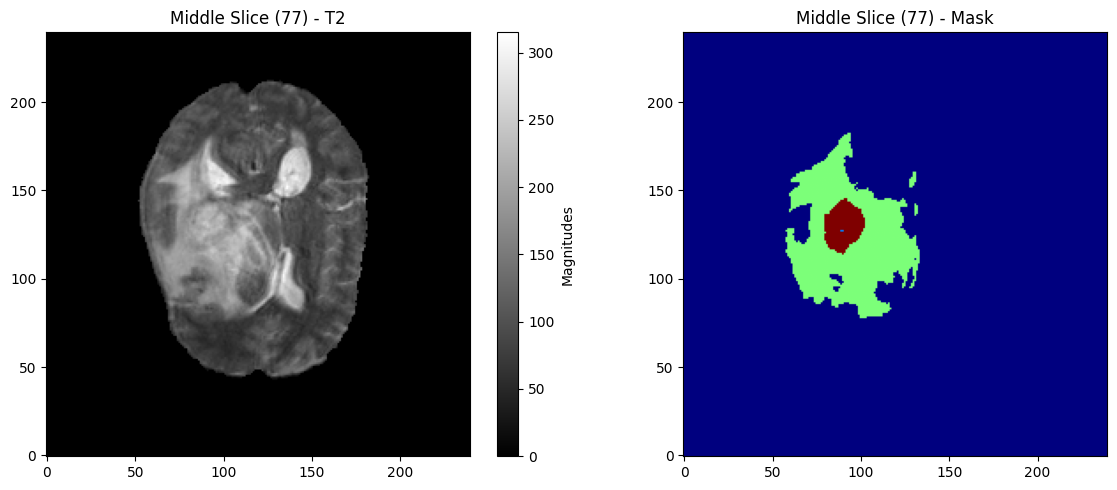

Displayed middle slice 77 from BraTS20_Training_001 - T2


In [67]:
# Display middle slice of sample patient to verify NIfTI files are readable
display_middle_slice_nii(sample_patient, modality='t2')

In [60]:
# Convert all patient folders in the BraTS20_Training directory to NIfTI files
failures = []
count = None       # Number of patient folders to convert for testing (set to None or remove for all)
if count is not None:
    print(f"Converting the first {count} patient folders for testing...")
    for patient_folder in patient_folders[:count]:
        patient_id = os.path.basename(patient_folder)
        output_nii = os.path.join(output_path, f"{patient_id}.nii")
        converted_successfully = normalise_nii(patient_folder, output_path, modality='t2')
        if not converted_successfully:
            failures.append(patient_id)
else:
    count = len(patient_folders)
    print("Converting all patient folders...")
    for i, patient_folder in enumerate(patient_folders):
        patient_id = os.path.basename(patient_folder)
        output_nii = os.path.join(output_path, f"{patient_id}.nii")
        converted_successfully = normalise_nii(patient_folder, output_path, modality='t2')
        if not converted_successfully:
            failures.append(patient_id)
        if i % 10 == 0:
            print(f"{i}/{count} patients processed")

if failures:
    raise RuntimeError(f"Conversions failed for patients ids: {', '.join(failures)}")

# Check count patient folders were processed
processed_files = glob.glob(os.path.join(output_path, 'BraTS20_Training_*'))
assert len(processed_files) == count, f"Expected {count} NIfTI files, but found {len(processed_files)}. Please check for any conversion errors."
print("All patient folders were successfully processed.")

Converting all patient folders...
0/369 patients processed
10/369 patients processed
20/369 patients processed
30/369 patients processed
40/369 patients processed
50/369 patients processed
60/369 patients processed
70/369 patients processed
80/369 patients processed
90/369 patients processed
100/369 patients processed
110/369 patients processed
120/369 patients processed
130/369 patients processed
140/369 patients processed
150/369 patients processed
160/369 patients processed
170/369 patients processed
180/369 patients processed
190/369 patients processed
200/369 patients processed
210/369 patients processed
220/369 patients processed
230/369 patients processed
240/369 patients processed
250/369 patients processed
260/369 patients processed
270/369 patients processed
280/369 patients processed
290/369 patients processed
300/369 patients processed
310/369 patients processed
320/369 patients processed
330/369 patients processed
340/369 patients processed
350/369 patients processed
360/3

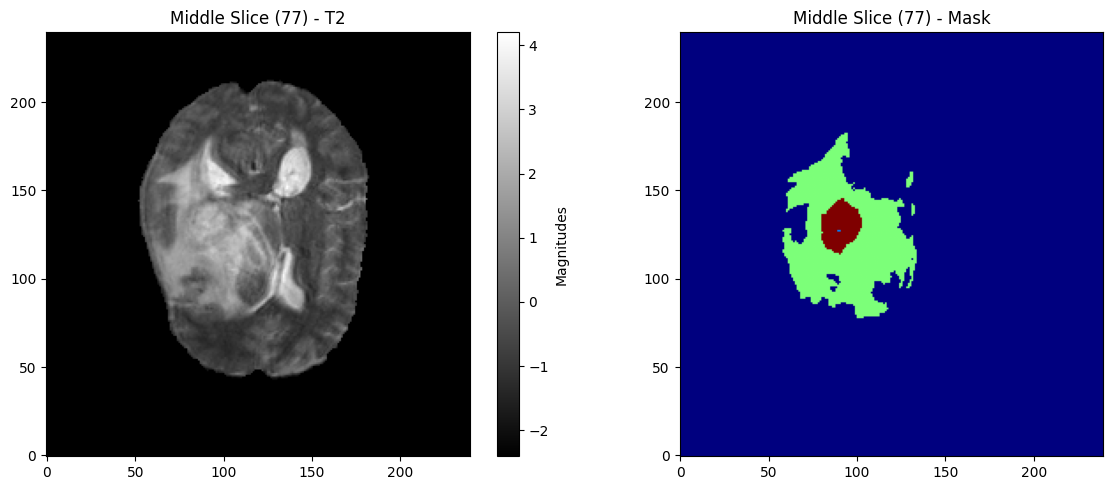

Displayed middle slice 77 from BraTS20_Training_001 - T2


In [68]:
sample_patient_output = output_path/"BraTS20_Training_001"
# Display middle slice of sample patient to verify NIfTI files are readable
display_middle_slice_nii(sample_patient_output, modality='t2')